# V. Evaluación

## Evaluación del modelo final contra el conjunto de prueba

Se ajustaron los modelos de Regresión de Ridge y Lasso optimizados con el conjunto de prueba, sin embargo, el que mejor se desempeño fue el XGBOOST. En esta sección se ajusta el modelo óptimo XGBOOST utilizando todos los datos de entrenamiento utilizando los parámetros óptimos obtenidos con la validación cruzada. Posteriormente se generan los resultados para subir a kaggle.

## Implementación con la librería xgb

### Reentrenamiento final de modelo con datos de entrenamiento y prueba con hiperparámetros optimizados.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
#print(os.listdir("datos"))
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV

A continuación se ajusta el modelo final sobre todos los datos de entrenamiento y prueba.

In [24]:
training = pd.read_csv("Data_Modelos/Entrenamiento_Modelos.csv")

In [25]:
import xgboost as xgb

In [26]:
xgbtrain = xgb.DMatrix(training.iloc[:, training.columns != 'item_cnt_day'].values, 
                       training.iloc[:, training.columns == 'item_cnt_day'].values)

param = {'max_depth':10, 
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.3, 
         'num_round':1000, 
         'seed':1,
         'silent':0,
         'eval_metric':'rmse'} # random parameters
bst = xgb.train(param, xgbtrain)

[19:15:13] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[19:15:37] C:\dev\libs\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 570 extra nodes, 0 pruned nodes, max_depth=10
[19:15:54] C:\dev\libs\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 648 extra nodes, 0 pruned nodes, max_depth=10
[19:16:11] C:\dev\libs\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 558 extra nodes, 0 pruned nodes, max_depth=10
[19:16:29] C:\dev\libs\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 610 extra nodes, 0 pruned nodes, max_depth=10
[19:16:46] C:\dev\libs\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 702 extra nodes, 0 pruned nodes, max_depth=10
[19:17:04] C:\dev\libs\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 738 extra nodes, 0 pruned nodes, max_depth=10
[19:17:21] C:\dev\libs\x

En la siguiente gráfica se muestra la importancia de las características.

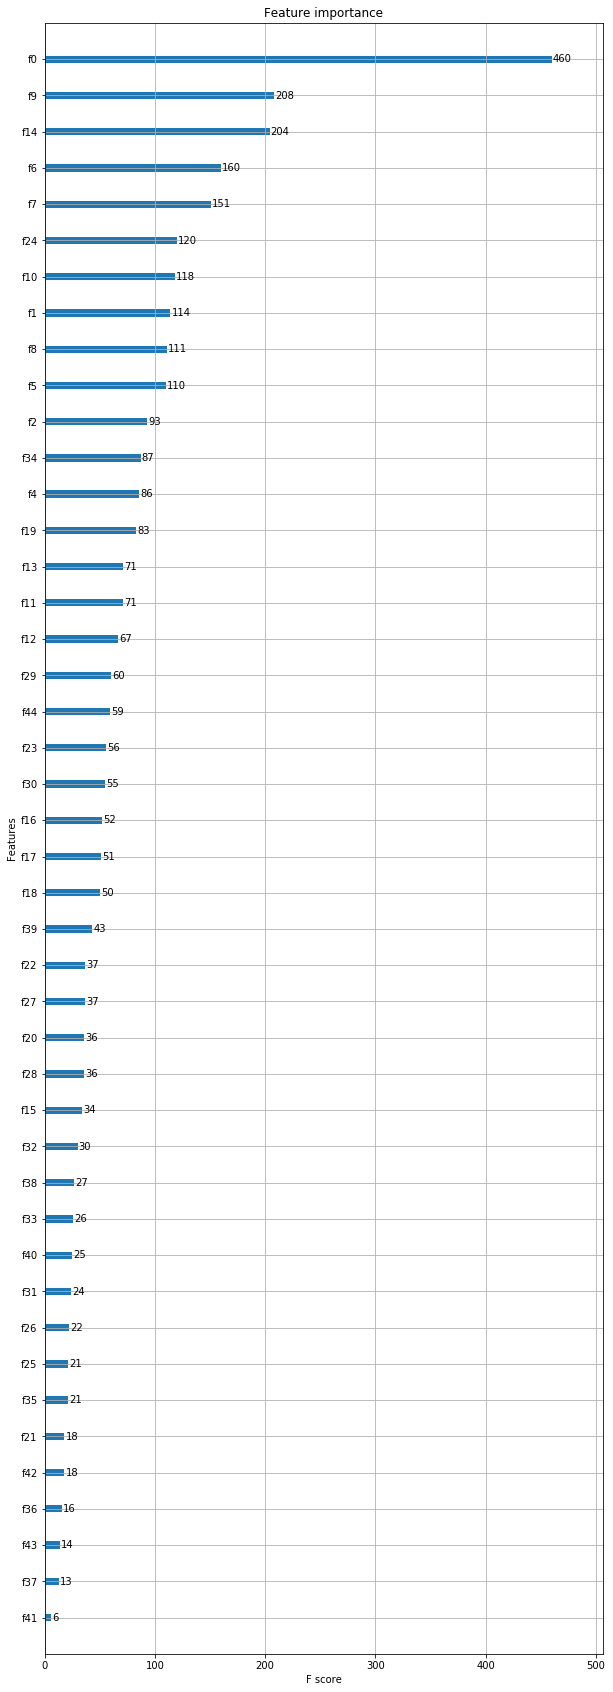

In [27]:
x=xgb.plot_importance(bst)
x.figure.set_size_inches(10, 30)

**Las características más importantes fueron:** 

* Por tienda el precio promedio (lag1)
* Por categoría las ventas promedio (lag1)
* Por producto por tienda el precio promedio (lag1)
* La tienda
* Por producto por tienda las ventas totales (lag1)
* Por tienda las ventas totales (lag1)
* El producto
* Por categoría las ventas promedio (lag2)

Puede concluirse que las variables de rezago 1 si tienen un poder explicativo para predecir hacia adelante las ventas de la compañía. Al menos este poder es más grande que el de rezagos más grandes.

In [42]:
cols = list(training.columns)
del cols[cols.index('item_cnt_day')] # Se elimina la variable target day
[cols[x] for x in [0, 8, 13, 5, 1, 6, 9, 2, 23]]

['Unnamed: 0',
 'shop_id_avg_item_price_lag_1',
 'item_category_id_avg_item_cnt_day_lag_1',
 'item_id_avg_item_price_lag_1',
 'shop_id',
 'item_id_sum_item_cnt_day_lag_1',
 'shop_id_sum_item_cnt_day_lag_1',
 'item_id',
 'item_category_id_avg_item_cnt_day_lag_2']

Una vez ajustado el modelo se procede a ajustar el modelo sobre el conjunto de prueba. Aqui tenemos una **matriz de diseño de prueba con 214,200 filas y 44 columnas**.

In [31]:
test = pd.read_csv("Data_Modelos/Prueba_Modelos.csv")

In [32]:
xgbpredict = xgb.DMatrix(test.values)

In [33]:
pred = bst.predict(xgbpredict)

Abajo se muestran algunas estadísticas descriptivas de la predicción de ventas mensuales para el mes de noviembre de 2015. Se observa que hay valores negativos el más chico de -0.57 y el máximo valor predicho fueron 386.47 ventas. Algunos valores quedan fuera del rango de 0 y 20 que marca la competencia, por lo que se deberán ajustar los valores extremos. 

In [34]:
pd.Series(pred).describe()

count    214200.000000
mean          0.312726
std           2.588174
min          -0.577917
25%           0.058912
50%           0.120540
75%           0.240221
max         386.479553
dtype: float64

Se ajustan los valores predichos para que queden en un rango de 0 y 20 como se especificó en las instrucciones de la competencia.

In [35]:
pred = pred.clip(0, 20)

Se puede ver que ahora todos los valores quedaron dentro del rango requerido.

In [37]:
pd.Series(pred).describe()

count    214200.000000
mean          0.284587
std           0.794151
min           0.000000
25%           0.058912
50%           0.120540
75%           0.240221
max          20.000000
dtype: float64

**Las ventas totales** de la empresa 1C durante el mes de noviembre de 2015 **se proyectaron en 60,966 unidades**.

In [36]:
pred.sum()

60966.914

In [38]:
sub_df = pd.DataFrame({'ID':test.index,'item_cnt_month': pred })

In [39]:
sub_df.head()

,ID,item_cnt_month
0,0,0.418297
1,1,0.192049
2,2,1.003844
3,3,0.212420
4,4,2.626056


### Generación y carga de datos de prueba en Kaggle (reporte de posición final en tablero)

Se genera el archivo de predicciones para subir a Kaggle, el cual tiene como propósito evaluar nuestro model con el conjunto de prueba.

In [40]:
sub_df.to_csv('Modelo_Final/submission.csv',index=False)

Se obtuvó un RMSE de 0.97, el cual cumple con el benchmark de 1.67. Con este modelo quedamos en el lugar 667 de 1986 concursantes.

<img src = "Modelo_Final/score_kaggle.png">


### Guardamos el modelo final en pickle para utilizarlo para hacer predicciones en el WEB SERVICE

Ahora guardamos el modelo en Pickle para posteriormente utilizarlo en el WEB SERVICE en Flask.

In [41]:
#from sklearn.externals import joblib
#joblib.dump(bst, 'Modelo_Final/modelo_xgb_prueba.pkl')

import pickle
with open("modelo_xgboost.pkl", "wb") as f:
    pickle.dump(bst_xgboost, f)

['Modelo_Final/modelo_xgb_prueba.pkl']

## Consideraciones finales

Los modelos xgboost que se ajustaron con el conjunto de prueba y que fueron evaluados en la plataforma de Kaggle superaron el benchmark de 1.677. El mejor modelo que se obtuvo sacó un RMSE de 0.97 colocando al modelo en el lugar 637 de 2981.

El gran reto de este conjunto de datos es completar la serie de tiempo y la toma de decisiones que ello implica. Por ejemplo, como tratar los productos donde no hubo observaciones, se deben rellenar con cero o imputar con estadísticas.

El otro reto que enfrentamos es la escala de los datos. Después de crear las características el conjunto de entrenamiento tenía casi tres millones de observaciones y 44 columnas. Al momento de cargar en memoria estos datos el tamaño de estos crecía exponencialmente en memoria. Como consecuencia, utilizar una máquina de Azure fue la solución. Sin embargo, al momento de explorar parámetros con el grid search la máquina de 20 gigas se trababa porque no podía guardar en memoria la información de cada iteración de modelos.

R dejó de ser útil para la etapa de entrenamiento porque los datos en memoria crecen muchísimo, al punto que no se puede trabajar. Para resolver este problema se repitió el proceso de limpieza de datos en Python, se llegó al mismo resultado en menos tiempo y con archivos de pesos más manejables.

El otro reto de este problema es la validación cruzada de una serie de tiempo y como implementar esto dentro de un pipeline eficiente y transparente.
